### Notebook: Preparing Time Independent Models

31 May 2024

Objectives:
- Further work on cross-validation
- Analysis and visuals
- Deal with age issue


## 0. Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, auc

# ------------------------------------------------
from catboost import CatBoostClassifier, Pool, cv #, MetricVisualizer
from catboost.utils import get_roc_curve


# ------------------------------------------------

data_path = "../../main_data/locale_specific_data/"

In [2]:
dog_df = pd.read_csv(data_path + "Sonoma_time_independent_data_akry.csv")

dog_df.head()

,breed,color,sex,size,date_of_birth,animal_id,intake_date,outcome_date,days_in_shelter,intake_type,...,outcome_adopt,outcome_adopt_subtype,intake_age,outcome_age,pop_control,sex_bin,size_bin,breed_pit,color_mix,intake_bin
0,PIT BULL,GRAY/WHITE,Female,MED,2012-09-03,A296009,2013-08-22,2014-04-14,235,TRANSFER,...,False,none,0.97,1.61,1,1,3,1,1,4
1,PIT BULL,BLUE/WHITE,Female,MED,2012-10-09,A294143,2013-08-31,2014-04-14,226,STRAY,...,False,none,0.89,1.51,1,1,3,1,1,0
2,CAROLINA DOG/MIX,GOLD/WHITE,Male,MED,2007-09-07,A281788,2013-09-19,2014-07-30,314,STRAY,...,False,none,6.03,6.90,0,0,3,0,1,0
3,CHIHUAHUA SH,TAN,Male,TOY,2007-10-01,A297574,2013-10-01,2014-01-01,92,OWNER SURRENDER,...,False,none,6.00,6.25,1,0,1,0,0,1
4,PIT BULL,TAN/WHITE,Male,MED,2012-10-29,A298002,2013-10-08,2014-05-22,226,STRAY,...,True,realtime,0.95,1.57,1,0,3,1,1,0


In [3]:
dog_df.columns

Index(['breed', 'color', 'sex', 'size', 'date_of_birth', 'animal_id',
       'intake_date', 'outcome_date', 'days_in_shelter', 'intake_type',
       'intake_subtype', 'outcome_type', 'outcome_subtype', 'intake_condition',
       'outcome_condition', 'dob_season', 'intake_season', 'outcome_season',
       'outcome_adopt', 'outcome_adopt_subtype', 'intake_age', 'outcome_age',
       'pop_control', 'sex_bin', 'size_bin', 'breed_pit', 'color_mix',
       'intake_bin'],
      dtype='object')

## 1. Deal with Ages

In [4]:
dog_df['intake_age'].value_counts().sort_index()

intake_age
-1.94     1
-0.76     1
-0.52     1
-0.23     1
-0.08     1
         ..
 17.00    1
 17.13    1
 18.00    1
 19.00    2
 20.99    1
Name: count, Length: 1256, dtype: int64

In [5]:
nonpos_age_df = dog_df[dog_df['intake_age'] <= 0]
nonpos_age_df = nonpos_age_df[['size', 'date_of_birth', 'intake_date']]
nonpos_age_df['size'].value_counts()

size
PUPPY    66
TOY       4
MED       2
X-LRG     1
Name: count, dtype: int64

In [ ]:
neg_age_df = dog_df[dog_df['intake_age'] < 0]
neg_age_df = neg_age_df[['size', 'date_of_birth', 'intake_date', 'intake_type']]
# neg_age_df['size'].value_counts()
neg_age_df

,size,date_of_birth,intake_date,intake_type
64,X-LRG,2014-03-19,2013-12-26,STRAY
73,PUPPY,2015-12-07,2013-12-29,STRAY
763,MED,2015-03-17,2014-09-10,STRAY
1330,TOY,2015-05-29,2015-04-30,STRAY
4138,PUPPY,2019-03-04,2019-03-01,STRAY
4469,MED,2020-07-06,2019-10-01,STRAY


In [6]:
zero_age_df = dog_df[dog_df['intake_age'] == 0]
zero_age_df = zero_age_df[['size', 'date_of_birth', 'intake_date', "intake_type"]]
zero_age_df['size'].value_counts()

size
PUPPY    64
TOY       3
Name: count, dtype: int64

In [7]:
zero_age_df['intake_type'].value_counts()

intake_type
STRAY              58
BORN HERE           6
OWNER SURRENDER     3
Name: count, dtype: int64

In [9]:
#remove negative age entries - clerical errors
dog_df=dog_df[dog_df.intake_age>=0].reset_index(drop=True)
print(len(dog_df))

dog_df.head()

6499


,breed,color,sex,size,date_of_birth,animal_id,intake_date,outcome_date,days_in_shelter,intake_type,...,outcome_adopt,outcome_adopt_subtype,intake_age,outcome_age,pop_control,sex_bin,size_bin,breed_pit,color_mix,intake_bin
0,PIT BULL,GRAY/WHITE,Female,MED,2012-09-03,A296009,2013-08-22,2014-04-14,235,TRANSFER,...,False,none,0.97,1.61,1,1,3,1,1,4
1,PIT BULL,BLUE/WHITE,Female,MED,2012-10-09,A294143,2013-08-31,2014-04-14,226,STRAY,...,False,none,0.89,1.51,1,1,3,1,1,0
2,CAROLINA DOG/MIX,GOLD/WHITE,Male,MED,2007-09-07,A281788,2013-09-19,2014-07-30,314,STRAY,...,False,none,6.03,6.90,0,0,3,0,1,0
3,CHIHUAHUA SH,TAN,Male,TOY,2007-10-01,A297574,2013-10-01,2014-01-01,92,OWNER SURRENDER,...,False,none,6.00,6.25,1,0,1,0,0,1
4,PIT BULL,TAN/WHITE,Male,MED,2012-10-29,A298002,2013-10-08,2014-05-22,226,STRAY,...,True,realtime,0.95,1.57,1,0,3,1,1,0


## 2. Training

### Create train-test split 

In [108]:
X_train, X_hold, y_train, y_hold = train_test_split(dog_df,
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2,
                                      random_state=1342)

In [42]:
X_train

,breed,color,sex,size,date_of_birth,animal_id,intake_date,outcome_date,days_in_shelter,intake_type,...,outcome_adopt,outcome_adopt_subtype,intake_age,outcome_age,pop_control,sex_bin,size_bin,breed_pit,color_mix,intake_bin
462,CHIHUAHUA SH,TRICOLOR,Male,TOY,2011-06-05,A307630,2014-06-05,2014-07-02,27,STRAY,...,True,realtime,3.00,3.08,1,0,1,0,1,0
6006,PAPILLON/MIX,AGOUTI,Unknown,PUPPY,2023-05-12,A417415,2023-05-12,2023-05-18,6,BORN HERE,...,False,none,0.00,0.02,0,0,0,0,0,6
2499,DACHSHUND/MIX,BLACK/TAN,Male,SMALL,2015-10-14,A343295,2016-10-08,2016-12-13,66,STRAY,...,True,online,0.99,1.17,1,0,2,0,1,0
6413,ROTTWEILER/GERM SHEPHERD,BROWN/BLACK,Female,MED,2020-11-02,A417722,2024-02-18,2024-03-07,18,CONFISCATE,...,False,none,3.30,3.35,1,1,3,0,1,3
1065,CAIRN TERRIER/MIX,BLACK/GRAY,Female,TOY,2013-08-05,A315676,2015-01-10,2015-03-28,77,STRAY,...,True,online,1.43,1.65,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4653,GERM SHEPHERD/SIBERIAN HUSKY,TAN/BLACK,Male,PUPPY,2019-12-15,A395731,2020-01-22,2020-02-13,22,OWNER SURRENDER,...,False,none,0.10,0.16,1,0,0,0,1,1
5128,AUST CATTLE DOG/MIX,RED MERLE,Male,MED,2015-06-25,A405244,2021-06-08,2022-05-12,338,STRAY,...,False,none,5.95,6.88,1,0,3,0,0,0
5707,CHINESE SHARPEI/MIX,BR BRINDLE,Female,LARGE,2020-10-15,A413693,2022-10-15,2022-11-22,38,STRAY,...,False,none,2.00,2.11,0,1,4,0,1,0
5735,LABRADOR RETR/MIX,BLACK,Male,MED,2020-11-12,A414134,2022-11-12,2022-12-24,42,STRAY,...,True,online,2.00,2.12,1,0,3,0,0,0


In [44]:
X_hold

,breed,color,sex,size,date_of_birth,animal_id,intake_date,outcome_date,days_in_shelter,intake_type,...,outcome_adopt,outcome_adopt_subtype,intake_age,outcome_age,pop_control,sex_bin,size_bin,breed_pit,color_mix,intake_bin
610,PIT BULL,BLUE/WHITE,Female,MED,2012-07-26,A309427,2014-07-26,2014-08-11,16,TRANSFER,...,False,none,2.00,2.05,0,1,3,1,1,4
1967,CHIHUAHUA SH/MIX,BLACK/BROWN,Male,MED,2008-10-18,A332421,2016-01-26,2016-02-19,24,STRAY,...,False,none,7.27,7.34,1,0,3,0,1,0
3710,GERM SHEPHERD/ALASKAN HUSKY,BLACK/TAN,Male,LARGE,2015-05-02,A374440,2018-07-05,2018-08-18,44,STRAY,...,True,realtime,3.18,3.30,1,0,4,0,1,0
680,CHIHUAHUA SH,BROWN/WHITE,Female,SMALL,2011-09-02,A310286,2014-08-18,2014-09-11,24,OWNER SURRENDER,...,False,none,2.96,3.02,1,1,2,0,1,1
280,CHIHUAHUA SH,BROWN/WHITE,Female,SMALL,2011-03-29,A304739,2014-03-29,2014-04-23,25,STRAY,...,True,realtime,3.00,3.07,1,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3427,CHIHUAHUA LH/MIX,BLACK/WHITE,Male,TOY,2017-02-03,A367906,2018-02-03,2018-02-16,13,STRAY,...,False,none,1.00,1.04,0,0,1,0,1,0
1326,PIT BULL/MIX,WHITE/BLACK,Male,MED,2014-07-06,A321170,2015-04-29,2015-08-06,99,STRAY,...,True,online,0.81,1.08,1,0,3,1,1,0
4854,POODLE MIN/MIX,WHITE,Male,SMALL,2006-07-22,A398920,2020-07-14,2020-07-28,14,STRAY,...,False,none,13.98,14.02,0,0,2,0,0,0
4480,DUTCH SHEPHERD/MIX,CHOCOLATE,Female,PUPPY,2019-08-10,A392176,2019-10-10,2019-10-12,2,OWNER SURRENDER,...,True,realtime,0.17,0.18,1,1,0,0,0,1


Training size:  5199
Holdout size:  1300

### Model 

#### All features

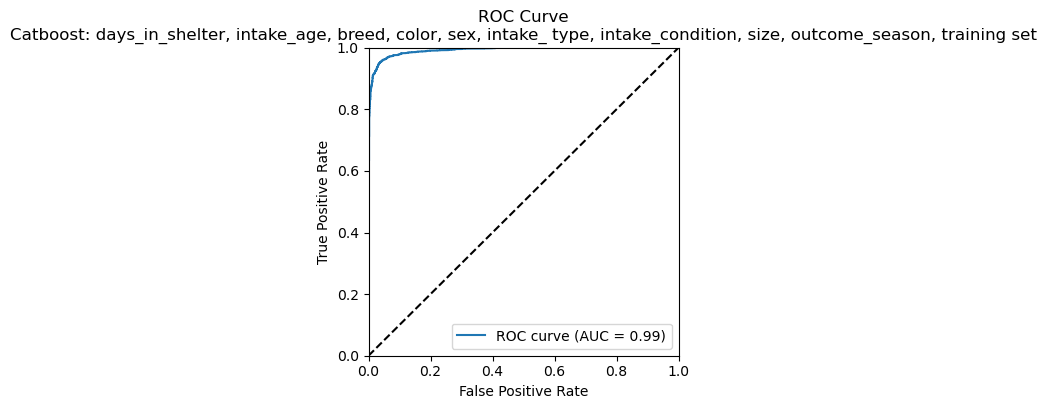

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[2047  286]
 [  49 2822]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    19.164922
1        intake_age    15.414941
2             breed    12.725534
3             color    11.557784
4  intake_condition     9.875424
5              size     9.260936
6    outcome_season     8.052521
7       intake_type     8.048518
8               sex     5.899420

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.88      0.92      2333
        True       0.91      0.98      0.94      2871

    accuracy                           0.94      5204
   macro avg       0.94      0.93      0.93      5204
weighted avg       0.94      0.94      0.94      5204



In [109]:

feat = 'days_in_shelter, intake_age, breed, color, sex, intake_ type, intake_condition, size, outcome_season'
model_name = "Catboost: "+ feat+", training set"
feature_list = [ 'sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del feat, model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



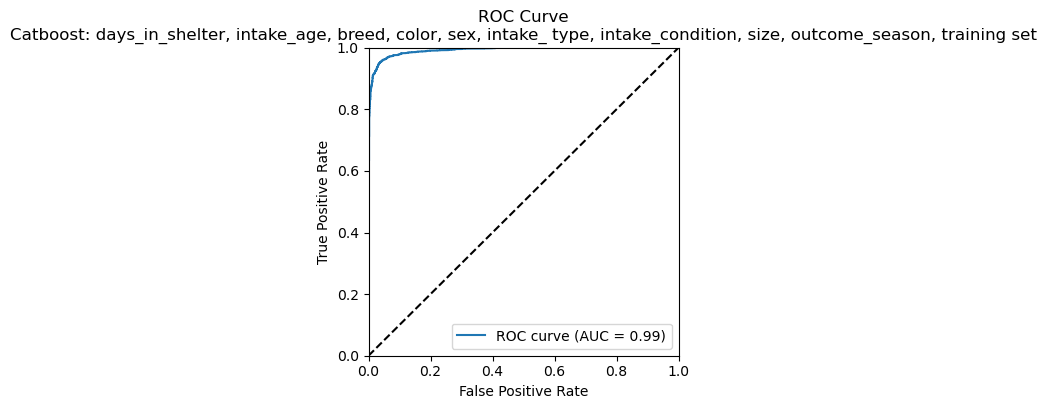

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[2047  286]
 [  49 2822]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    19.164922
1        intake_age    15.414941
2             breed    12.725534
3             color    11.557784
4  intake_condition     9.875424
5              size     9.260936
6    outcome_season     8.052521
7       intake_type     8.048518
8               sex     5.899420

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.88      0.92      2333
        True       0.91      0.98      0.94      2871

    accuracy                           0.94      5204
   macro avg       0.94      0.93      0.93      5204
weighted avg       0.94      0.94      0.94      5204



In [130]:

feat = 'days_in_shelter, intake_age, breed, color, sex, intake_ type, intake_condition, size, outcome_season'
model_name = "Catboost: "+ feat+", training set"
feature_list = [ 'sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, 
        # eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del feat, model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



#### All but one feature

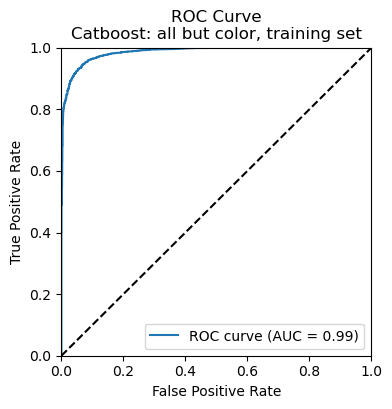

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[1964  369]
 [  59 2812]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    20.348218
1        intake_age    16.287690
2             breed    14.112704
3  intake_condition    12.956823
4              size    12.445145
5    outcome_season     9.210952
6       intake_type     7.855183
7               sex     6.783285

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.84      0.90      2333
        True       0.88      0.98      0.93      2871

    accuracy                           0.92      5204
   macro avg       0.93      0.91      0.92      5204
weighted avg       0.92      0.92      0.92      5204



In [110]:

feat = 'all but color' #'days_in_shelter, intake_age, breed, color, sex, intake_ type, intake_condition, size, outcome_season'
model_name = "Catboost: "+ feat+", training set"
feature_list = [ 'sex',
                'size',
                'breed', 
                # 'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del feat, model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



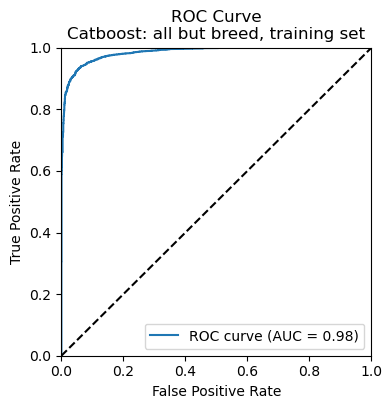

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[1963  370]
 [  71 2800]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    20.764346
1        intake_age    17.285114
2  intake_condition    12.491827
3             color    12.255855
4              size    11.112294
5    outcome_season     9.635632
6       intake_type     9.254391
7               sex     7.200541

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.84      0.90      2333
        True       0.88      0.98      0.93      2871

    accuracy                           0.92      5204
   macro avg       0.92      0.91      0.91      5204
weighted avg       0.92      0.92      0.91      5204



In [111]:

feat = 'all but breed' #'days_in_shelter, intake_age, breed, color, sex, intake_ type, intake_condition, size, outcome_season'
model_name = "Catboost: "+ feat+", training set"
feature_list = [ 'sex',
                'size',
                #'breed', 
                 'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del feat, model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



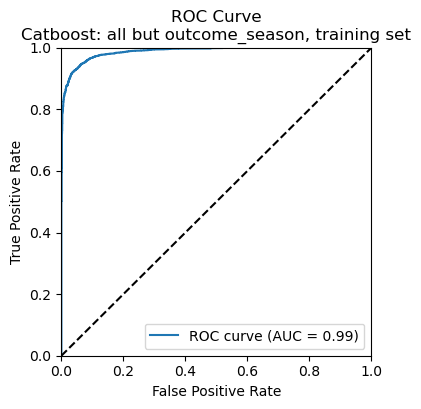

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[1958  375]
 [  55 2816]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    19.299462
1        intake_age    15.856989
2             color    13.072320
3  intake_condition    12.896089
4             breed    12.884588
5              size    11.209015
6       intake_type     8.145634
7               sex     6.635904

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.84      0.90      2333
        True       0.88      0.98      0.93      2871

    accuracy                           0.92      5204
   macro avg       0.93      0.91      0.92      5204
weighted avg       0.92      0.92      0.92      5204



In [112]:

feat = 'all but outcome_season' #'days_in_shelter, intake_age, breed, color, sex, intake_ type, intake_condition, size, outcome_season'
model_name = "Catboost: "+ feat+", training set"
feature_list = [ 'sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                # 'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del feat, model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



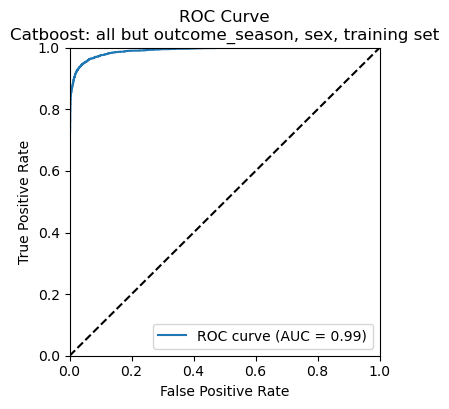

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[2043  290]
 [  53 2818]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    21.326071
1        intake_age    16.016804
2  intake_condition    13.604548
3             breed    13.536178
4             color    12.688176
5              size    12.271487
6       intake_type    10.556736

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.88      0.92      2333
        True       0.91      0.98      0.94      2871

    accuracy                           0.93      5204
   macro avg       0.94      0.93      0.93      5204
weighted avg       0.94      0.93      0.93      5204



In [113]:

feat = 'all but outcome_season, sex' #'days_in_shelter, intake_age, breed, color, sex, intake_ type, intake_condition, size, outcome_season'
model_name = "Catboost: "+ feat+", training set"
feature_list = [ #'sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                # 'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del feat, model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



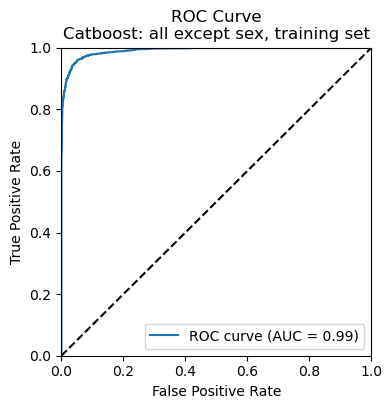

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[2021  312]
 [  50 2821]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    19.428953
1        intake_age    15.909764
2  intake_condition    14.013460
3             breed    12.133759
4             color    11.602380
5              size    10.483214
6    outcome_season     8.727509
7       intake_type     7.700962

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.87      0.92      2333
        True       0.90      0.98      0.94      2871

    accuracy                           0.93      5204
   macro avg       0.94      0.92      0.93      5204
weighted avg       0.93      0.93      0.93      5204



In [114]:

feat = 'all except sex' #'days_in_shelter, intake_age, breed, color, sex, intake_ type, intake_condition, size, outcome_season'
model_name = "Catboost: "+ feat+", training set"
feature_list = [ #'sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del feat, model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



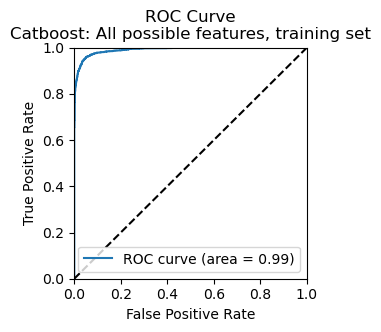

Confusion Matrix for training set:
 [[2021  312]
 [  50 2821]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    19.428953
1        intake_age    15.909764
2  intake_condition    14.013460
3             breed    12.133759
4             color    11.602380
5              size    10.483214
6    outcome_season     8.727509
7       intake_type     7.700962

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.87      0.92      2333
        True       0.90      0.98      0.94      2871

    accuracy                           0.93      5204
   macro avg       0.94      0.92      0.93      5204
weighted avg       0.93      0.93      0.93      5204



In [115]:
model_name = "Catboost: All possible features, training set"
feature_list = [#'sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        plot=False)
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))


## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix for training set:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # feature importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices

del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



#### Using only one feature

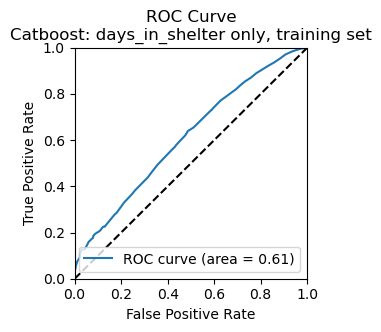

Confusion Matrix for training set:
 [[ 803 1530]
 [ 597 2274]]
Used dataset leave statistics for fstr calculation
        Feature Id  Importances
0  days_in_shelter        100.0

Classification Report:
              precision    recall  f1-score   support

       False       0.57      0.34      0.43      2333
        True       0.60      0.79      0.68      2871

    accuracy                           0.59      5204
   macro avg       0.59      0.57      0.56      5204
weighted avg       0.59      0.59      0.57      5204



In [116]:
model_name = "Catboost: days_in_shelter only, training set"
feature_list = [#'sex',
                # 'size',
                # 'breed', 
                # 'color',
                 'days_in_shelter',
                # 'outcome_season',
                # 'intake_age',
                # 'intake_condition',
                # 'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        plot=False)
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))


## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)

plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix for training set:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # feature importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



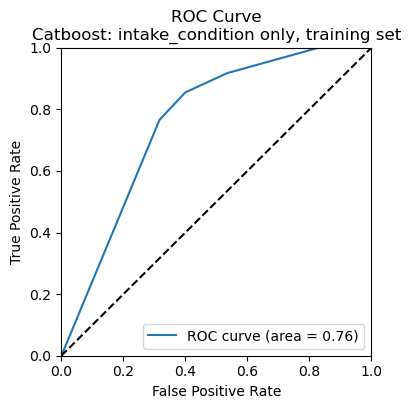

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[1401  932]
 [ 417 2454]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition        100.0

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.60      0.68      2333
        True       0.72      0.85      0.78      2871

    accuracy                           0.74      5204
   macro avg       0.75      0.73      0.73      5204
weighted avg       0.75      0.74      0.74      5204



In [117]:

model_name = "Catboost: intake_condition only, training set"
feature_list = [#'sex',
                # 'size',
                # 'breed', 
                # 'color',
                # 'days_in_shelter',
                # 'outcome_season',
                # 'intake_age',
                'intake_condition',
                # 'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



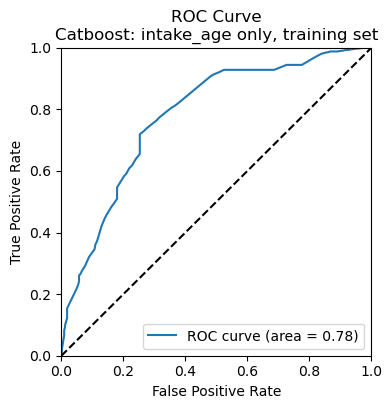

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[1211 1122]
 [ 267 2604]]
Used dataset leave statistics for fstr calculation
   Feature Id  Importances
0  intake_age        100.0

Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.52      0.64      2333
        True       0.70      0.91      0.79      2871

    accuracy                           0.73      5204
   macro avg       0.76      0.71      0.71      5204
weighted avg       0.75      0.73      0.72      5204



In [118]:

model_name = "Catboost: intake_age only, training set"
feature_list = [#'sex',
                # 'size',
                # 'breed', 
                # 'color',
                # 'days_in_shelter',
                # 'outcome_season',
                'intake_age',
                # 'intake_condition',
                # 'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



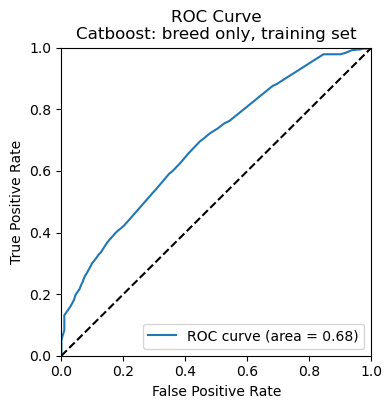

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[ 741 1592]
 [ 354 2517]]
Used dataset leave statistics for fstr calculation
  Feature Id  Importances
0      breed        100.0

Classification Report:
              precision    recall  f1-score   support

       False       0.68      0.32      0.43      2333
        True       0.61      0.88      0.72      2871

    accuracy                           0.63      5204
   macro avg       0.64      0.60      0.58      5204
weighted avg       0.64      0.63      0.59      5204



In [119]:

feat = "breed"
model_name = "Catboost: "+ feat+" only, training set"
feature_list = [ feat, #'sex',
                # 'size',
                # 'breed', 
                # 'color',
                # 'days_in_shelter',
                # 'outcome_season',
                # 'intake_age',
                # 'intake_condition',
                # 'intake_type'
                #, 'outcome_adopt_subtype'
                ]
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, eval_set=(X_t, y_t), 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve\n'+model_name)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))

# # confusion graph
# plt.figure(figsize=(4, 3))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
#             'Pred Neg', 'Pred Pos'], yticklabels=['Act Neg', 'Actual Pos'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # importance graph
# feat_arry = np.array(feature_list)
# importances = clf.get_feature_importance()
# sorted_indices = np.argsort(importances)[::-1] 
# plt.figure(figsize=(5, 3))
# plt.bar(range(len(feature_list)), importances[sorted_indices])
# plt.xticks(range(len(feature_list)), feat_arry[sorted_indices], rotation=90)
# plt.title("Feature Importance")
# plt.show()
# del feat_arry, importances, sorted_indices


del feat, model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



### Cross validation

#### using built in cv function

In [120]:
# use built in cv function

feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                # 'outcome_adopt_subtype'
                ]
X_t = X_train[feature_list]
X_t = X_t.astype(str)
pool = Pool(X_t, y_train, cat_features=feature_list, feature_names=feature_list)


# cv_dataset = pool
#Pool(data=cv_data,label=labels,cat_features=cat_features)

params = {"iterations": 1000,
          "depth": 6,
          "loss_function": "Logloss",
          "verbose": False,
          "roc_file": "roc-file"}

scores = cv(pool,
            params,
            fold_count=9,
            partition_random_seed=1342,
            plot="True"
            )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/9]

bestTest = 0.4532106961
bestIteration = 698

Training on fold [1/9]

bestTest = 0.451290796
bestIteration = 628

Training on fold [2/9]

bestTest = 0.521813224
bestIteration = 927

Training on fold [3/9]

bestTest = 0.4523192002
bestIteration = 742

Training on fold [4/9]

bestTest = 0.4802271378
bestIteration = 888

Training on fold [5/9]

bestTest = 0.4938899392
bestIteration = 829

Training on fold [6/9]

bestTest = 0.4636517774
bestIteration = 357

Training on fold [7/9]

bestTest = 0.4757854792
bestIteration = 549

Training on fold [8/9]

bestTest = 0.4526954213
bestIteration = 768



In [121]:
# use built in cv function

feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type'
                # 'outcome_adopt_subtype'
                ]
X_t = X_train[feature_list]
X_t = X_t.astype(str)
pool = Pool(X_t, y_train, cat_features=feature_list, feature_names=feature_list)


params = {"iterations": 500,
          "depth": 6,
          "loss_function": "Logloss",
          "verbose": False,
          "roc_file": "roc-file"}

scores = cv(pool,
            params,
            fold_count=9,
            partition_random_seed=1342,
            plot="True"
            )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/9]

bestTest = 0.4539212699
bestIteration = 490

Training on fold [1/9]

bestTest = 0.4521204116
bestIteration = 478

Training on fold [2/9]

bestTest = 0.5239254373
bestIteration = 493

Training on fold [3/9]

bestTest = 0.4537215257
bestIteration = 491

Training on fold [4/9]

bestTest = 0.4822743572
bestIteration = 496

Training on fold [5/9]

bestTest = 0.4989749038
bestIteration = 499

Training on fold [6/9]

bestTest = 0.4636517774
bestIteration = 357

Training on fold [7/9]

bestTest = 0.4765567725
bestIteration = 495

Training on fold [8/9]

bestTest = 0.454350654
bestIteration = 499



#### Using Stratified kfold

all features


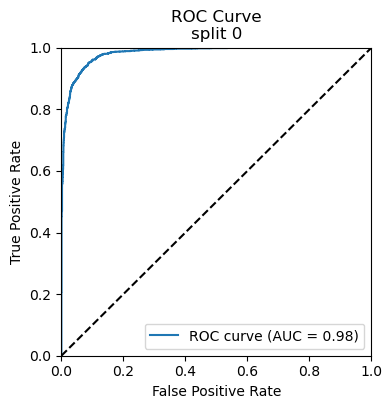


[[152  93]
 [ 38 296]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition    22.388166
1        intake_age    17.151920
2   days_in_shelter    14.076996
3             color     9.756916
4             breed     9.689944
5              size     8.240592
6               sex     6.673577
7       intake_type     6.376681
8    outcome_season     5.645208
              precision    recall  f1-score   support

       False       0.80      0.62      0.70       245
        True       0.76      0.89      0.82       334

    accuracy                           0.77       579
   macro avg       0.78      0.75      0.76       579
weighted avg       0.78      0.77      0.77       579


2 --------------------------------------------------


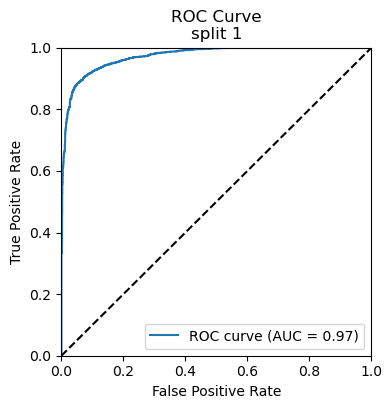


[[151  96]
 [ 41 291]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition    25.147463
1        intake_age    17.468777
2       intake_type    13.489271
3   days_in_shelter    13.088235
4             breed    10.237260
5               sex     7.732171
6              size     6.576058
7             color     3.602029
8    outcome_season     2.658735
              precision    recall  f1-score   support

       False       0.79      0.61      0.69       247
        True       0.75      0.88      0.81       332

    accuracy                           0.76       579
   macro avg       0.77      0.74      0.75       579
weighted avg       0.77      0.76      0.76       579


3 --------------------------------------------------


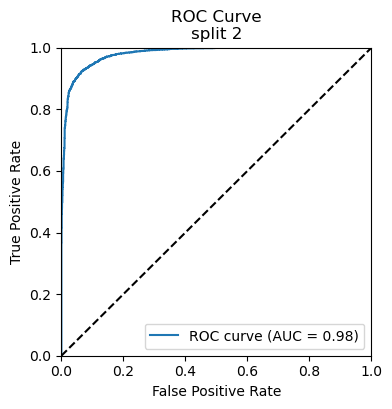


[[143 105]
 [ 40 290]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    16.483009
1        intake_age    15.945148
2  intake_condition    12.790805
3             breed    11.320056
4              size    10.297949
5             color    10.024857
6    outcome_season     8.524702
7       intake_type     8.316191
8               sex     6.297283
              precision    recall  f1-score   support

       False       0.78      0.58      0.66       248
        True       0.73      0.88      0.80       330

    accuracy                           0.75       578
   macro avg       0.76      0.73      0.73       578
weighted avg       0.75      0.75      0.74       578


4 --------------------------------------------------


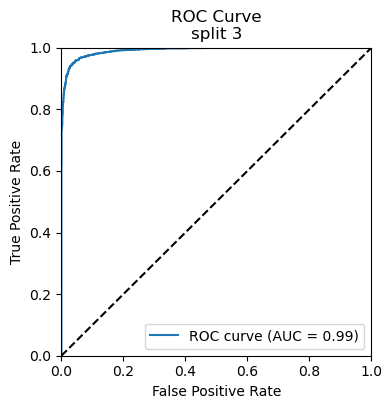


[[158  82]
 [ 37 301]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition    18.029781
1        intake_age    16.674359
2   days_in_shelter    14.264267
3             breed    11.734886
4       intake_type     9.993650
5              size     9.120769
6             color     7.728966
7    outcome_season     7.229569
8               sex     5.223752
              precision    recall  f1-score   support

       False       0.81      0.66      0.73       240
        True       0.79      0.89      0.83       338

    accuracy                           0.79       578
   macro avg       0.80      0.77      0.78       578
weighted avg       0.80      0.79      0.79       578


5 --------------------------------------------------


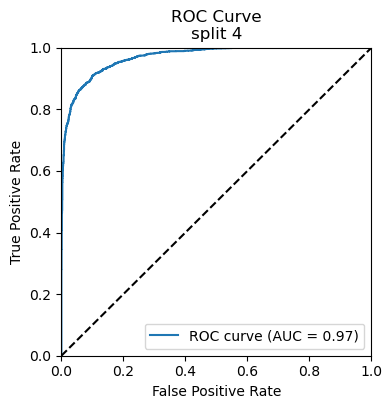


[[154  81]
 [ 32 311]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition    22.846134
1        intake_age    16.508460
2   days_in_shelter    15.256911
3             breed     9.760475
4              size     9.648614
5       intake_type     9.082308
6    outcome_season     6.883000
7             color     6.106856
8               sex     3.907242
              precision    recall  f1-score   support

       False       0.83      0.66      0.73       235
        True       0.79      0.91      0.85       343

    accuracy                           0.80       578
   macro avg       0.81      0.78      0.79       578
weighted avg       0.81      0.80      0.80       578


6 --------------------------------------------------


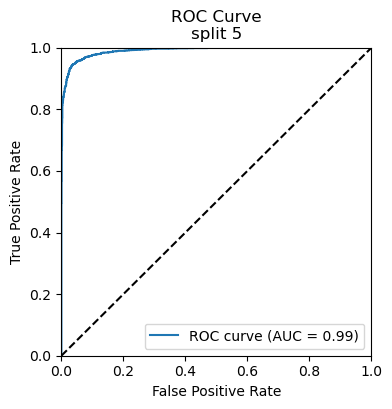


[[152 113]
 [ 35 278]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    18.604583
1        intake_age    16.386616
2  intake_condition    15.879865
3             breed    12.111877
4             color    10.375120
5              size     8.667592
6    outcome_season     7.126195
7       intake_type     6.574610
8               sex     4.273542
              precision    recall  f1-score   support

       False       0.81      0.57      0.67       265
        True       0.71      0.89      0.79       313

    accuracy                           0.74       578
   macro avg       0.76      0.73      0.73       578
weighted avg       0.76      0.74      0.74       578


7 --------------------------------------------------


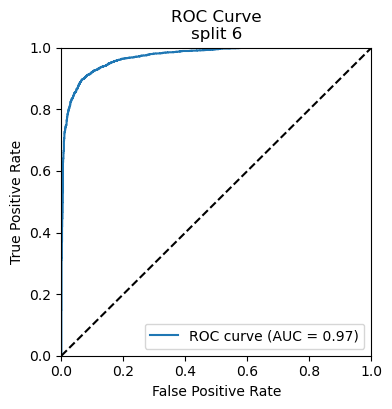


[[146 103]
 [ 51 278]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition    24.627388
1        intake_age    14.235405
2   days_in_shelter    12.624201
3              size    10.809525
4             breed    10.093599
5       intake_type     7.729833
6               sex     7.331834
7    outcome_season     6.407893
8             color     6.140323
              precision    recall  f1-score   support

       False       0.74      0.59      0.65       249
        True       0.73      0.84      0.78       329

    accuracy                           0.73       578
   macro avg       0.74      0.72      0.72       578
weighted avg       0.73      0.73      0.73       578


8 --------------------------------------------------


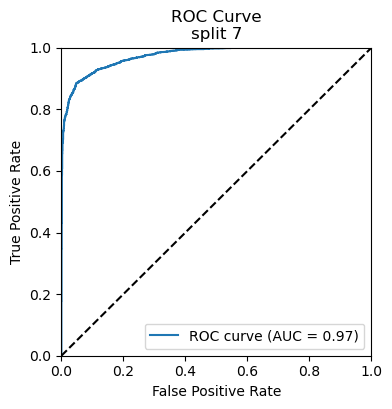


[[132 119]
 [ 38 289]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition    24.711754
1        intake_age    16.665038
2   days_in_shelter    13.137975
3             breed    11.460370
4              size     9.241475
5       intake_type     8.101097
6             color     7.221371
7    outcome_season     5.535445
8               sex     3.925474
              precision    recall  f1-score   support

       False       0.78      0.53      0.63       251
        True       0.71      0.88      0.79       327

    accuracy                           0.73       578
   macro avg       0.74      0.70      0.71       578
weighted avg       0.74      0.73      0.72       578


9 --------------------------------------------------


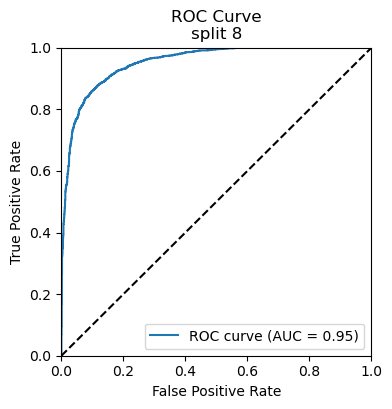


[[149 103]
 [ 28 298]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition    27.091790
1        intake_age    16.278053
2   days_in_shelter    12.536461
3       intake_type    10.543361
4               sex     7.993686
5              size     7.371641
6             breed     7.219244
7             color     5.639935
8    outcome_season     5.325831
              precision    recall  f1-score   support

       False       0.84      0.59      0.69       252
        True       0.74      0.91      0.82       326

    accuracy                           0.77       578
   macro avg       0.79      0.75      0.76       578
weighted avg       0.79      0.77      0.77       578


10 --------------------------------------------------


In [124]:
mdl_title = "all features"
feature_list = ['sex',
                'size',
                'breed', 
                'color',
                'days_in_shelter',
                'outcome_season',
                'intake_age',
                'intake_condition',
                'intake_type',
                # 'outcome_adopt_subtype'
                ]
tree_depth = 6
cv_splits  = 9

kfold  = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1342)
scores = pd.DataFrame(columns=['accuracy','tree_count'], index=range(cv_splits))

print(mdl_title)
i = 0
for t_idx, h_idx in kfold.split(X_train, X_train.outcome_adopt):
    X_t = dog_df[feature_list].iloc[t_idx]
    X_t = X_t.astype(str)
    y_t = dog_df.outcome_adopt.iloc[t_idx]
    X_h = dog_df[feature_list].iloc[h_idx]
    X_h = X_h.astype(str)
    y_h = dog_df.outcome_adopt.iloc[h_idx]

    pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)

    clf  = CatBoostClassifier(iterations=1000, learning_rate=0.1, loss_function="Logloss", depth=tree_depth, task_type="CPU").fit(pool, eval_set=(X_h, y_h), verbose=False)
    # scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))
    ## ROC curve - get data from catboost, plot with plt
    (fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--') #line y=x
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve\n'+ 'split '+str(i))
    plt.legend(loc="lower right")
    plt.show()

    scores.loc[i, "tree_count"] = clf.tree_count_
    scores.loc[i, "accuracy"]   = accuracy_score(y_true = y_h, y_pred = clf.predict(X_h))
    print()
    print(confusion_matrix(y_true = y_h, y_pred = clf.predict(X_h)))
    print()
    print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
    print(classification_report(y_true = y_h, y_pred = clf.predict(X_h)))
    print()
    del clf, pool   
    del X_t, y_t, X_h, y_h
    i+=1
    print(i+1,'-'*50)

del kfold, scores

In [123]:
mdl_title = "only intake_condition"
feature_list = [#'sex',
#                 'size',
#                 'breed', 
#                 'color',
#                 'days_in_shelter',
#                 'outcome_season',
#                 'intake_age',
                'intake_condition',
                # 'intake_type',
                # 'outcome_adopt_subtype'
                ]
tree_depth = 6
cv_splits  = 9

kfold  = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1342)
scores = pd.DataFrame(columns=['accuracy','tree_count'], index=range(cv_splits))

print(mdl_title)
i = 0
for t_idx, h_idx in kfold.split(X_train, X_train.outcome_adopt):
    X_t = dog_df[feature_list].iloc[t_idx]
    X_t = X_t.astype(str)
    y_t = dog_df.outcome_adopt.iloc[t_idx]
    X_h = dog_df[feature_list].iloc[h_idx]
    X_h = X_h.astype(str)
    y_h = dog_df.outcome_adopt.iloc[h_idx]

    pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)

    clf  = CatBoostClassifier(iterations=1000, learning_rate=0.1, loss_function="Logloss", depth=tree_depth, task_type="CPU").fit(pool, eval_set=(X_h, y_h), verbose=False)
    scores.loc[i, "tree_count"] = clf.tree_count_
    scores.loc[i, "accuracy"]   = accuracy_score(y_true = y_h, y_pred = clf.predict(X_h))
    print()
    print(confusion_matrix(y_true = y_h, y_pred = clf.predict(X_h)))
    print()
    print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
    print(classification_report(y_true = y_h, y_pred = clf.predict(X_h)))
    print()
    del clf, pool   
    del X_t, y_t, X_h, y_h
    i+=1
    print(i+1,'-'*50)

del kfold, scores

only intake_condition

[[136 109]
 [ 38 296]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition        100.0
              precision    recall  f1-score   support

       False       0.78      0.56      0.65       245
        True       0.73      0.89      0.80       334

    accuracy                           0.75       579
   macro avg       0.76      0.72      0.73       579
weighted avg       0.75      0.75      0.74       579


2 --------------------------------------------------

[[143 104]
 [ 42 290]]

Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0  intake_condition        100.0
              precision    recall  f1-score   support

       False       0.77      0.58      0.66       247
        True       0.74      0.87      0.80       332

    accuracy                           0.75       579
   macro avg       0.75      0.73      0.73       579
weighted avg       0.75      0.75      0.

In [132]:
dog_df['breed_pure'] = 1*(dog_df.breed.str.contains('/')==False)


In [134]:
dog_df['breed_pure'].value_counts()


breed_pure
0    3389
1    3116
Name: count, dtype: int64

# Work with final model

In [11]:
final_feature_list = [ 'size', 'days_in_shelter', 'outcome_season','intake_age','intake_condition']


#### Train Test split
X_train, X_hold, y_train, y_hold

In [12]:
X_train, X_hold, y_train, y_hold = train_test_split(dog_df,
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2,
                                      random_state=1342)

#### Build Model

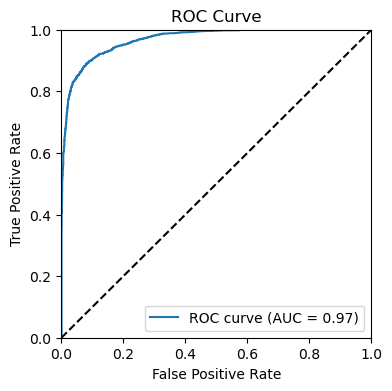

Model params:
{'iterations': 1000, 'learning_rate': 0.03, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[1831  501]
 [ 127 2740]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0        intake_age    24.357772
1   days_in_shelter    22.054542
2  intake_condition    21.885492
3              size    16.189695
4    outcome_season    15.512499

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.79      0.85      2332
        True       0.85      0.96      0.90      2867

    accuracy                           0.88      5199
   macro avg       0.89      0.87      0.88      5199
weighted avg       0.89      0.88      0.88      5199



In [18]:

feature_list = final_feature_list
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.03

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))


del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



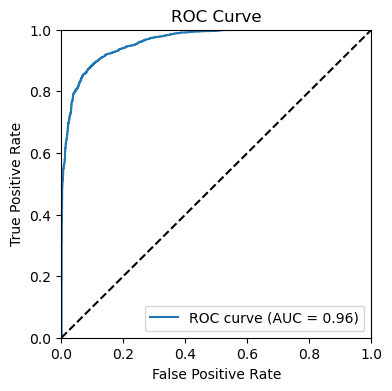

Model params:
{'iterations': 1000, 'learning_rate': 0.05, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[1820  512]
 [ 151 2716]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    25.813551
1        intake_age    24.700843
2  intake_condition    17.945930
3              size    16.351051
4    outcome_season    15.188625

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.78      0.85      2332
        True       0.84      0.95      0.89      2867

    accuracy                           0.87      5199
   macro avg       0.88      0.86      0.87      5199
weighted avg       0.88      0.87      0.87      5199



In [20]:

feature_list = final_feature_list
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.05

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))


del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



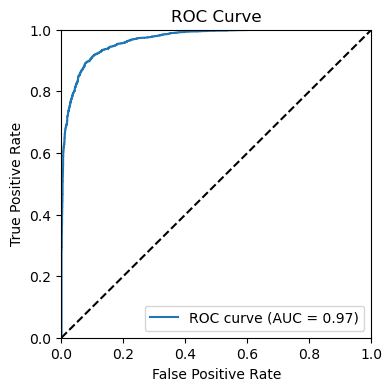

Model params:
{'iterations': 1000, 'learning_rate': 0.08, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[1852  480]
 [ 117 2750]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    24.928238
1        intake_age    23.767066
2  intake_condition    17.928664
3              size    17.075252
4    outcome_season    16.300781

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.79      0.86      2332
        True       0.85      0.96      0.90      2867

    accuracy                           0.89      5199
   macro avg       0.90      0.88      0.88      5199
weighted avg       0.89      0.89      0.88      5199



In [21]:

feature_list = final_feature_list
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.08

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))

## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))


del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



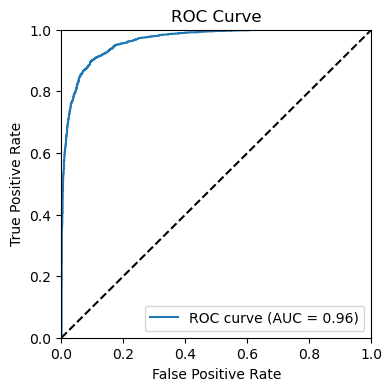

Model params:
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'Logloss'}
Confusion Matrix:
 [[1915  417]
 [ 139 2728]]
Used dataset leave statistics for fstr calculation
         Feature Id  Importances
0   days_in_shelter    27.111799
1        intake_age    23.938522
2  intake_condition    16.687355
3              size    16.570918
4    outcome_season    15.691406

Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.82      0.87      2332
        True       0.87      0.95      0.91      2867

    accuracy                           0.89      5199
   macro avg       0.90      0.89      0.89      5199
weighted avg       0.90      0.89      0.89      5199



In [22]:

feature_list = final_feature_list
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, 
        verbose=False, 
        # plot=True
        )
# scores = pd.DataFrame(columns=['test_accuracy','tree_count'], index=range(cv_splits))
## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
# print("Area under the ROC curve : %f" % roc_auc)
# print(fpr)
# print(tpr)
# print(thresholds)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig(roc_j)

del fpr, tpr, thresholds, roc_auc


print('Model params:')
print(clf.get_params())

confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
print('Confusion Matrix:\n', confusion)
print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
print()
print("Classification Report:")
print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))


del feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



#### Final model
final_model

In [73]:
feature_list = final_feature_list
tree_depth = 6
X_t = X_train[feature_list]
X_t = X_t.astype(str)
y_t = y_train
lrn_rate = 0.1

pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, 
                          loss_function="Logloss", depth=tree_depth)
clf.fit(pool, 
        verbose=False, 
        plot=True
        )
final_model = clf
train_predictions = final_model.predict(pool)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

##### Final model predictions on holdout set

In [53]:
X_h = X_hold[feature_list]
X_h = X_h.astype(str)
y_h = y_hold
pool_h = Pool(X_h, y_h, cat_features=feature_list, feature_names=feature_list)
test_predictions = final_model.predict(pool_h)
confusion = confusion_matrix(y_true = y_h, y_pred = test_predictions)
print(test_predictions)
print(confusion)

[ True False  True ...  True  True False]
[[372 211]
 [123 594]]


Confusion Matrix

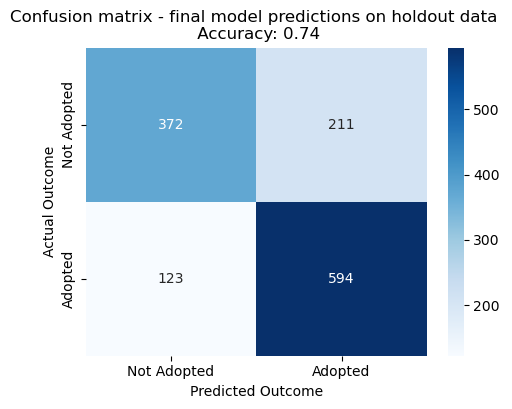

In [76]:
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# Transform to df for easier plotting
# cm_df = pd.DataFrame(confusion,
#                      index = ['True','False']
#                      columns = ['Adopted','Not Adopted'])
y_pred = test_predictions

plt.figure(figsize=(5.5,4))
# sns.heatmap(confusion, annot=True)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[
            'Not Adopted', 'Adopted'], yticklabels=['Not Adopted', 'Adopted'])
plt.title('Confusion matrix - final model predictions on holdout data \n Accuracy: {0:.2f}'.format(accuracy_score(y_hold, y_pred)))
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

In [61]:
dog_df['outcome_adopt'].value_counts()


outcome_adopt
True     3584
False    2915
Name: count, dtype: int64

In [63]:
overall_adoption_rate = 3584/(3584+2915)
print(overall_adoption_rate)

0.5514694568395138


In [64]:
X_train['outcome_adopt'].value_counts()


outcome_adopt
True     2867
False    2332
Name: count, dtype: int64

In [66]:
adoption_rate_train = 2867/(2867+2332)
print(adoption_rate_train)

0.5514522023466051


In [69]:
#Confusion matrix entries
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
TP = confusion[1,1]

In [70]:
#sensitivity
TP/(TP+FN)


0.8284518828451883

In [72]:
#specificity
TN/(TN+FP)

0.6380789022298456

In [75]:
FN/(TN+FP+FN+TP)

0.09461538461538462